In [1]:
#Script to obtain data 
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

#Libraries to create the multiclass model
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
#Import tensorflow and disable the v2 behavior and eager mode
import tensorflow as tf
tf.compat.v1.disable_eager_execution()
tf.compat.v1.disable_v2_behavior()

#Library to validate the model
from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.preprocessing import LabelEncoder,MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, accuracy_score

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
!pip install tensorflow

In [3]:
!pip install keras

In [4]:
df = pd.read_csv("C:/Users/Sanyam/Downloads/Spotify-Machine-Learning-master/Spotify-Machine-Learning-master/data/data_moods.csv")

In [5]:
!pip install scikeras

In [6]:
col_features = df.columns[6:-3]
X= MinMaxScaler().fit_transform(df[col_features])
X2 = np.array(df[col_features])
Y = df['mood']

In [7]:
#Encodethe categories
encoder = LabelEncoder()
encoder.fit(Y)
encoded_y = encoder.transform(Y)


#Convert to  dummy (Not necessary in my case)
dummy_y = np_utils.to_categorical(encoded_y)

X_train,X_test,Y_train,Y_test = train_test_split(X,encoded_y,test_size=0.2,random_state=15)

target = pd.DataFrame({'mood':df['mood'].tolist(),'encode':encoded_y}).drop_duplicates().sort_values(['encode'],ascending=True)
target

,mood,encode
5,Calm,0
4,Energetic,1
0,Happy,2
1,Sad,3


In [1]:
def base_model():
    #Create the model
    model = Sequential()
    #Add 1 layer with 8 nodes,input of 4 dim with relu function
    model.add(Dense(8,input_dim=10,activation='relu'))
    #Add 1 layer with output 3 and softmax function
    model.add(Dense(4,activation='softmax'))
    #Compile the model using sigmoid loss function and adam optim
    model.compile(loss='categorical_crossentropy',optimizer='adam',
                 metrics=['accuracy'])
    return model

In [9]:
#Configure the model
estimator = KerasClassifier(build_fn=base_model,epochs=300,batch_size=200,verbose=0)

<ipython-input-9-2230d3e76bd3>:2: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.
  estimator = KerasClassifier(build_fn=base_model,epochs=300,batch_size=200,verbose=0)


In [10]:
#Evaluate the model using KFold cross validation
kfold = KFold(n_splits=10,shuffle=True)
results = cross_val_score(estimator,X,encoded_y,cv=kfold)
print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100,results.std()*100))

C:\Users\Sanyam\anaconda3\lib\site-packages\keras\engine\training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
C:\Users\Sanyam\anaconda3\lib\site-packages\keras\engine\training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
C:\Users\Sanyam\anaconda3\lib\site-packages\keras\engine\training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
C:\Users\Sanyam\anaconda3\lib\site-packages\keras\engine\training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be use

Baseline: 77.25% (4.38%)


C:\Users\Sanyam\anaconda3\lib\site-packages\keras\engine\training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


In [11]:
estimator.fit(X_train,Y_train)
y_preds = estimator.predict(X_test)

C:\Users\Sanyam\anaconda3\lib\site-packages\keras\engine\training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


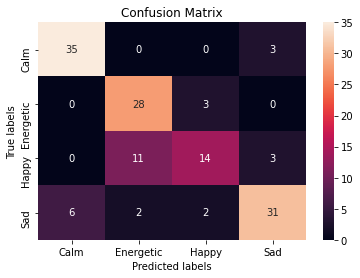

Accuracy Score 0.782608695652174


In [12]:
cm = confusion_matrix(Y_test,y_preds)
ax = plt.subplot()
sns.heatmap(cm,annot=True,ax=ax)

labels = target['mood']
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)
plt.show()

print("Accuracy Score",accuracy_score(Y_test,y_preds))

In [13]:
def predict_mood(id_song):
    #Join the model and the scaler in a Pipeline
    pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
                                                                             batch_size=200,verbose=0))])
    #Fit the Pipeline
    pip.fit(X2,encoded_y)

    #Obtain the features of the song
    preds = get_songs_features(id_song)
    #Pre-process the features to input the Model
    preds_features = np.array(preds[0][6:-2]).reshape(-1,1).T

    #Predict the features of the song
    results = pip.predict(preds_features)

    mood = np.array(target['mood'][target['encode']==int(results)])
    name_song = preds[0][0]
    artist = preds[0][2]

    return print("{0} by {1} is a {2} song".format(name_song,artist,mood[0].upper()))
    #print(f"{name_song} by {artist} is a {mood[0].upper()} song")

In [24]:
import spotipy
import time
from IPython.core.display import clear_output
from spotipy import SpotifyClientCredentials, util


client_id='b6da93c771b94eb584ca290ab8c1a105'
client_secret='1d0da28e84374eab84687e8ce9a020cd'
redirect_uri='http://localhost:8891/callback/'
username = '11178035349'
scope = 'playlist-modify-public'

#Credentials to access the Spotify Music Data
manager = SpotifyClientCredentials(client_id,client_secret)
sp = spotipy.Spotify(client_credentials_manager=manager)

#Credentials to access to  the Spotify User's Playlist, Favorite Songs, etc. 
token = util.prompt_for_user_token(username,scope,client_id,client_secret,redirect_uri) 
spt = spotipy.Spotify(auth=token)


def get_albums_id(ids):
    album_ids = []
    results = sp.artist_albums(ids)
    for album in results['items']:
        album_ids.append(album['id'])
    return album_ids

def get_album_songs_id(ids):
    song_ids = []
    results = sp.album_tracks(ids,offset=0)
    for songs in results['items']:
        song_ids.append(songs['id'])
    return song_ids

def get_songs_features(ids):

    meta = sp.track(ids)
    features = sp.audio_features(ids)

    # meta
    name = meta['name']
    album = meta['album']['name']
    artist = meta['album']['artists'][0]['name']
    release_date = meta['album']['release_date']
    length = meta['duration_ms']
    popularity = meta['popularity']
    ids =  meta['id']

    # features
    acousticness = features[0]['acousticness']
    danceability = features[0]['danceability']
    energy = features[0]['energy']
    instrumentalness = features[0]['instrumentalness']
    liveness = features[0]['liveness']
    valence = features[0]['valence']
    loudness = features[0]['loudness']
    speechiness = features[0]['speechiness']
    tempo = features[0]['tempo']
    key = features[0]['key']
    time_signature = features[0]['time_signature']

    track = [name, album, artist, ids, release_date, popularity, length, danceability, acousticness,
            energy, instrumentalness, liveness, valence, loudness, speechiness, tempo, key, time_signature]
    columns = ['name','album','artist','id','release_date','popularity','length','danceability','acousticness','energy','instrumentalness',
                'liveness','valence','loudness','speechiness','tempo','key','time_signature']
    return track,columns

def get_songs_artist_ids_playlist(ids):
    playlist = sp.playlist_tracks(ids)
    songs_id = []
    artists_id = []
    for result in playlist['items']:
        songs_id.append(result['track']['id'])
        for artist in result['track']['artists']:
            artists_id.append(artist['id'])
    return songs_id,artists_id

def download_albums(music_id,artist=False):
    
    if artist == True:
        ids_album = get_albums_id(music_id)
    else:
        if type(music_id) == list:
            ids_album = music_id
        elif type(music_id) == str:
            ids_album = list([music_id])

    tracks = []
    for ids in ids_album:
        #Obtener Ids de canciones en album
        song_ids = get_album_songs_id(ids=ids)
        #Obtener feautres de canciones en album
        ids2 = song_ids
        
        print(f"Album Length: {len(song_ids)}")
         
        time.sleep(.6)   
        track, columns = get_songs_features(ids2)
        tracks.append(track)

        print(f"Song Added: {track[0]} By {track[2]} from the album {track[1]}")
        clear_output(wait = True)
        
    clear_output(wait = True)
    print("Music Downloaded!")
 
    return tracks,columns

def download_playlist(id_playlist,n_songs):
    songs_id = []
    tracks = []

    for i in range(0,n_songs,100):
        playlist = spt.playlist_tracks(id_playlist,limit=100,offset=i)
        
        for songs in playlist['items']:
            songs_id.append(songs['track']['id'])
    
    counter = 1
    for ids in songs_id:
        
        time.sleep(.6)
        track,columns = get_songs_features(ids)
        tracks.append(track)

        print(f"Song {counter} Added:")
        print(f"{track[0]} By {track[2]} from the album {track[1]}")
        clear_output(wait = True)
        counter+=1
    
    clear_output(wait = True)
    print("Music Downloaded!")

    return tracks,columns

In [25]:
predict_mood('0VjIjW4GlUZAMYd2vXMi3b')

<ipython-input-23-1cc8c2e6486a>:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
C:\Users\Sanyam\anaconda3\lib\site-packages\keras\engine\training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Blinding Lights by The Weeknd is a ENERGETIC song


In [23]:
predict_mood('7FlHNJT4TC120CDvFOHzei')

<ipython-input-13-1cc8c2e6486a>:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,


Rewrite The Stars by Various Artists is a HAPPY song


C:\Users\Sanyam\anaconda3\lib\site-packages\keras\engine\training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


In [24]:
predict_mood('251PNRmJU9KcUnFQAB5t6I')

<ipython-input-13-1cc8c2e6486a>:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,


Kal Ho Naa Ho by Shankar-Ehsaan-Loy is a SAD song


C:\Users\Sanyam\anaconda3\lib\site-packages\keras\engine\training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


In [25]:
predict_mood('3fPgIknlkDWXs1l2noKZbp')

<ipython-input-13-1cc8c2e6486a>:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,


Kar Gayi Chull by Badshah is a HAPPY song


C:\Users\Sanyam\anaconda3\lib\site-packages\keras\engine\training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


In [14]:
from keras.models import Sequential
from keras.layers import Dense
from keras.utils.vis_utils import plot_model
model = Sequential()
model.add(Dense(2, input_dim=1, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


In [15]:
from keras.models import Sequential
from keras.layers import Dense
from keras.utils.vis_utils import plot_model
model = Sequential()
model.add(Dense(2, input_dim=1, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


In [16]:
!pip install pydot

In [17]:
from keras.models import Sequential
from keras.layers import Dense
from keras.utils.vis_utils import plot_model
model = Sequential()
model.add(Dense(2, input_dim=1, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


In [18]:
!pip install graphviz

In [19]:
from keras.models import Sequential
from keras.layers import Dense
from keras.utils.vis_utils import plot_model
model = Sequential()
model.add(Dense(8, input_dim=10, activation='relu'))
model.add(Dense(4, activation='sigmoid'))
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


In [20]:

from keras.models import Sequential
from keras.layers import Dense
model = Sequential()
model.add(Dense(8, input_dim=10, activation='relu'))
model.add(Dense(4, activation='softmax'))
print(model.summary())

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_30 (Dense)            (None, 8)                 88        
                                                                 
 dense_31 (Dense)            (None, 4)                 36        
                                                                 
Total params: 124
Trainable params: 124
Non-trainable params: 0
_________________________________________________________________
None


In [42]:
from keras.models import Sequential
from keras.layers import Dense
from keras.utils.vis_utils import plot_model
model = Sequential()
model.add(Dense(8, input_dim=10, activation='relu'))
model.add(Dense(4, activation='softmax'))
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


In [44]:
from keras.models import Sequential
from keras.layers import Dense
from keras.utils.vis_utils import plot_model
model = Sequential()
model.add(Dense(8, input_dim=10, activation='relu'))
model.add(Dense(4, activation='softmax'))
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


In [35]:
from keras.models import Sequential
from keras.layers import Dense
from keras.utils.vis_utils import plot_model
model = Sequential()
model.add(Dense(2, input_dim=1, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


In [36]:
from keras.models import Sequential
from keras.layers import Dense
from keras.utils.vis_utils import plot_model
model = Sequential()
model.add(Dense(2, input_dim=1, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


In [45]:
tf.keras.utils.model_to_dot(
    model,
    show_shapes=False,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
    subgraph=False,
    layer_range=None,
)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')
